In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

"""Import dependencies"""
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet18
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:

class MyDatasetViT(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = []
        self.labels = []
        self.class_names = ['axion', 'cdm', 'no_sub']
        self.transform = transform

        print(f"Loading dataset from: {data_dir}")
        print(f"Looking for classes: {self.class_names}")

        for idx, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            print(f"--- Processing class: {class_name} ---")

            if not os.path.exists(class_dir):
                print(f"[ERROR] Directory not found: {class_dir}")
                continue

            files = os.listdir(class_dir)

            for file_name in files:
                if file_name.endswith('.npy'):
                    file_path = os.path.join(class_dir, file_name)
                    loaded_data = np.load(file_path, allow_pickle=True)

                    if class_name == 'axion':
                        image = loaded_data[0]
                    else:
                        image = loaded_data

                    # [DEBUG] Print the shape of the raw numpy array
                    print(f"  [DEBUG] Loaded '{file_name}'. Raw numpy shape: {image.shape}")

                    # Ensure the image is a 2D array (H, W) before adding channel dimension.
                    if image.ndim != 2:
                        image = np.squeeze(image)

                    # Convert to a float tensor and add a channel dimension -> [1, H, W]
                    image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

                    # [DEBUG] Print the shape of the final tensor being stored in the dataset
                    print(f"  [DEBUG] Storing tensor with final shape: {image_tensor.shape}\n")

                    self.data.append(image_tensor)
                    self.labels.append(idx)

        print("\n--- Dataset Loading Complete ---")
        print(f"Total images loaded: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        This method is called by the DataLoader to get one item from the dataset.
        The debug prints here are CRITICAL for finding the error.
        """
        #print(f"--- Getting item index: {idx} ---")

        # Retrieve the pre-loaded tensor and its label
        image = self.data[idx]
        label = self.labels[idx]

        # [DEBUG] Print shape BEFORE the transform is applied
        #print(f"  [DEBUG] Shape of tensor BEFORE transform: {image.shape}")

        # Apply transformations (e.g., resizing) if they are provided
        if self.transform:
            image = self.transform(image)
            # [DEBUG] Print shape AFTER the transform is applied
            #print(f"  [DEBUG] Shape of tensor AFTER transform: {image.shape}")
        else:
            #print("  [DEBUG] No transform was applied.")
            pass

        return image, label

In [ ]:

# Import the transforms module
from torchvision import transforms
# Hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 100

# Data Directories
train_dir = '/content/drive/MyDrive/Model_III_dataset/Model_III'
#val_dir = '../dataset/dataset/val'

print(f"Training Directory: {train_dir}")
#print(f"Validation Directory: {val_dir}")

vit_transforms = transforms.Compose([
    # transforms.ToTensor(), # Removed ToTensor()
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90), # Can be any angle range
])

# Create Datasets and Dataloaders
#train_dataset = MyDataset(train_dir)
#val_dataset = MyDataset(val_dir)
#dataset = MyDatasetViT(train_dir, vit_transforms)
#train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.75, 0.15, 0.1])

#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
#val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)

#print(f"Batch Size: {batch_size}")
#print(f"Number of Training Batches: {len(train_loader)}")
#print(f"Number of Validation Batches: {len(val_loader)}")

#Save the dataloader so that we don't have to bear with this pain again
#torch.save(train_loader, '/content/drive/MyDrive/Model_III_dataset/train_loader.pth')
#torch.save(val_loader, '/content/drive/MyDrive/Model_III_dataset/val_loader.pth')

Training Directory: /content/drive/MyDrive/Model_III_dataset/Model_III


In [ ]:
#import data loaders from file
train_loader = torch.load('/content/drive/MyDrive/model_alpha/vit_train_loader.pth', weights_only=False)
val_loader = torch.load('/content/drive/MyDrive/model_alpha/vit_val_loader.pth', weights_only=False)

In [ ]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, trunc_normal_
from torch import Tensor

# --- Helper Classes from Original Swin Transformer ---

class Mlp(nn.Module):
    """ Multi-Layer Perceptron """
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Partitions the input tensor into non-overlapping windows.
    Args:
        x: (B, H, W, C)
        window_size (tuple[int]): Window size (height, width).

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Reverses the window partitioning.
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (tuple[int]): Window size (height, width).
        H (int): Height of image.
        W (int): Width of image.

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size[0] / window_size[1]))
    x = windows.view(
        B, H // window_size[0], W // window_size[1], window_size[0], window_size[1], -1
    )
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both shifted and non-shifted windows.
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):
        super().__init__()
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )

        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w], indexing="ij"))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)
        ].view(
            self.window_size[0] * self.window_size[1],
            self.window_size[0] * self.window_size[1],
            -1,
        )
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block."""

    def __init__(
        self,
        dim,
        input_resolution,
        num_heads,
        window_size=(5, 5),
        shift_size=(0, 0),
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio

        if min(self.input_resolution) <= min(self.window_size):
            self.shift_size = (0, 0)
            self.window_size = self.input_resolution

        assert 0 <= self.shift_size[0] < self.window_size[0], "shift_size must be less than window_size"
        assert 0 <= self.shift_size[1] < self.window_size[1], "shift_size must be less than window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

        if self.shift_size[0] > 0 or self.shift_size[1] > 0:
            H, W = self.input_resolution
            img_mask = torch.zeros((1, H, W, 1))
            h_slices = (
                slice(0, -self.window_size[0]),
                slice(-self.window_size[0], -self.shift_size[0]),
                slice(-self.shift_size[0], None),
            )
            w_slices = (
                slice(0, -self.window_size[1]),
                slice(-self.window_size[1], -self.shift_size[1]),
                slice(-self.shift_size[1], None),
            )
            cnt = 0
            for h in h_slices:
                for w in w_slices:
                    img_mask[:, h, w, :] = cnt
                    cnt += 1

            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size[0] * self.window_size[1])
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(
                attn_mask == 0, float(0.0)
            )
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        if self.shift_size[0] > 0 or self.shift_size[1] > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = x_windows.view(-1, self.window_size[0] * self.window_size[1], C)

        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)

        if self.shift_size[0] > 0 or self.shift_size[1] > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size[0], self.shift_size[1]), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage. """

    def __init__(
        self,
        dim,
        input_resolution,
        depth,
        num_heads,
        window_size,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth

        self.blocks = nn.ModuleList(
            [
                SwinTransformerBlock(
                    dim=dim,
                    input_resolution=input_resolution,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=(0, 0) if (i % 2 == 0) else (window_size[0] // 2, window_size[1] // 2),
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )

        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding """

    def __init__(self, img_size=(150, 150), patch_size=(10, 10), in_chans=1, embed_dim=96, norm_layer=None):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.num_patches = self.patches_resolution[0] * self.patches_resolution[1]
        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, H, W = x.shape
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        if self.norm is not None:
            x = self.norm(x)
        return x


class TransformerLSABlock(nn.Module):
    """
    A standard Transformer block with Multi-Head Self-Attention and a Feed-Forward Network.
    This is a placeholder for the block used in the RelativisticPhysicalInformedEncoder.
    """
    def __init__(self, embed_dim, num_heads, num_patches, num_hidden_neurons, activation_function, device, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, num_hidden_neurons),
            activation_function,
            nn.Dropout(dropout),
            nn.Linear(num_hidden_neurons, embed_dim),
            nn.Dropout(dropout)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Attention part
        shortcut = x
        x = self.norm1(x)
        x, _ = self.attn(x, x, x)
        x = self.dropout(x)
        x = x + shortcut

        # MLP part
        shortcut = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + shortcut
        return x


class RelativisticPhysicalInformedEncoder(nn.Module):
    """
    A PyTorch module to perform inverse gravitational lensing using the Singular Isothermal Sphere (SIS) model.
    """
    def __init__( self,
                  image_size: int,
                  patch_size: int,
                  embed_dim: int,
                  num_patches: int,
                  num_heads: int,
                  num_hidden_neurons: int,
                  transformer_activation_function: nn.Module,
                  num_transformer_blocks: int,
                  dropout: float = 0.1,
                  pixel_scale:float =0.101,
                  k_min: float = 0.8,
                  k_max: float = 1.2,
                  eps: float = 1e-8
                  ):
        super(RelativisticPhysicalInformedEncoder, self).__init__()
        self.pixel_scale = pixel_scale
        self.profile_size = image_size
        self.half_profile_size = self.profile_size // 2
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.num_hidden_neurons = num_hidden_neurons
        self.transformer_activation_function = transformer_activation_function
        self.num_transformer_blocks = num_transformer_blocks
        self.k_min = k_min
        self.k_max = k_max
        self.eps = eps

        self.transformer = nn.ModuleList()
        self.num_neurons_flatten = (self.num_patches) * embed_dim # Removed +1 for CLS token as it's not used

        for _ in range(num_transformer_blocks):
            self.transformer.append(
                TransformerLSABlock(embed_dim,
                                    num_heads,
                                    self.num_patches,
                                    num_hidden_neurons,
                                    transformer_activation_function,
                                    None, # Device is handled in forward pass
                                    dropout)
            )

        self.compressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.num_neurons_flatten, self.profile_size * self.profile_size),
            nn.Sigmoid()
        )

        # Create coordinate grids, but don't move to device yet
        x_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size - 1, self.profile_size) * self.pixel_scale
        y_coordinates = torch.linspace(-self.half_profile_size, self.half_profile_size - 1, self.profile_size) * self.pixel_scale
        grid_x, grid_y = torch.meshgrid(x_coordinates, y_coordinates, indexing='ij')
        self.register_buffer('grid_x', grid_x)
        self.register_buffer('grid_y', grid_y)


    def forward(self, input_images: Tensor, patches: Tensor)->Tensor:
        """
        Forward pass through the module.
        """
        # Ensure input_images is 2D (B, H*W) if it's not already
        if input_images.dim() == 3:
            input_images = input_images.squeeze(1)

        batch_size = input_images.shape[0]
        device = input_images.device

        # Move grid tensors to the correct device
        flat_grid_x = self.grid_x.flatten().to(device)
        flat_grid_y = self.grid_y.flatten().to(device)

        # Pass patches through transformer blocks
        k_transformed = patches
        for layer in self.transformer:
            k_transformed = layer(k_transformed)

        # Generate k using the compressor
        k_sigmoid = self.compressor(k_transformed)

        k_sigmoid = k_sigmoid.view(-1, self.profile_size, self.profile_size)
        k_sigmoid_flat = k_sigmoid.view(-1, self.profile_size * self.profile_size)
        k_sigmoid_flat = self.k_min + (self.k_max - self.k_min) * k_sigmoid_flat

        flat_input_images = input_images.view(batch_size, -1)
        non_zero_mask = (flat_grid_x != 0) | (flat_grid_y != 0)
        k_sigmoid_non_zero = k_sigmoid_flat[:, non_zero_mask]

        shape_k_sigmoid_non_zero = k_sigmoid_non_zero.shape
        k = k_sigmoid_non_zero.view(shape_k_sigmoid_non_zero[0], 1, 1, shape_k_sigmoid_non_zero[1])

        non_zero_x = flat_grid_x[non_zero_mask]
        non_zero_y = flat_grid_y[non_zero_mask]
        non_zero_radius = torch.sqrt(non_zero_x ** 2 + non_zero_y ** 2)
        non_zero_radius = non_zero_radius[None, None, None, :]

        shifted_x = (non_zero_x[None, None, None, :] - k * non_zero_x[None, None, None, :] / (non_zero_radius + self.eps))
        shifted_y = (non_zero_y[None, None, None, :] - k * non_zero_y[None, None, None, :] / (non_zero_radius + self.eps))

        shifted_x_idx = torch.round(shifted_x / self.pixel_scale + self.half_profile_size).long()
        shifted_y_idx = torch.round(shifted_y / self.pixel_scale + self.half_profile_size).long()

        # Clamp indices to be within the valid range [0, profile_size-1]
        shifted_x_idx.clamp_(0, self.profile_size - 1)
        shifted_y_idx.clamp_(0, self.profile_size - 1)

        output_images = torch.zeros(batch_size, self.profile_size, self.profile_size, device=device)
        flat_output_images = output_images.view(batch_size, -1)

        one_d_indices = shifted_x_idx * self.profile_size + shifted_y_idx
        one_d_indices = one_d_indices.view(batch_size, -1)

        input_values_at_original_positions = flat_input_images[:, non_zero_mask]

        # Use scatter_add_ for safe parallel updates
        # To handle multiple source pixels mapping to the same target pixel, we average them.
        # We need a count tensor for averaging.
        counts = torch.zeros_like(flat_output_images)
        ones = torch.ones_like(input_values_at_original_positions)

        flat_output_images.scatter_add_(1, one_d_indices, input_values_at_original_positions)
        counts.scatter_add_(1, one_d_indices, ones)

        # Avoid division by zero
        flat_output_images = torch.where(counts > 0, flat_output_images / counts, 0)

        output_images = flat_output_images.view(batch_size, self.profile_size, self.profile_size)

        max_values = torch.amax(output_images, dim=(1, 2), keepdim=True)
        output_images = output_images / (max_values + self.eps)

        return output_images


class SwinTransformerForClassification(nn.Module):
    """
    Swin Transformer with an optional Relativistic Physics Informed Encoder.
    """
    def __init__(self, img_size=(150, 150), patch_size=(10, 10), in_chans=1, num_classes=3,
                 embed_dim=96, depths=[2, 2, 6], num_heads=[3, 6, 12],
                 window_size=(5, 5), mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_relativistic_encoder=False, relativistic_encoder_blocks=2, **kwargs):
        super().__init__()

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim)
        self.mlp_ratio = mlp_ratio
        self.use_relativistic_encoder = use_relativistic_encoder

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        if self.use_relativistic_encoder:
            self.relativistic_encoder = RelativisticPhysicalInformedEncoder(
                image_size=img_size[0],
                patch_size=patch_size[0],
                embed_dim=embed_dim,
                num_patches=num_patches,
                num_heads=num_heads[0], # Use heads from the first Swin stage
                num_hidden_neurons=int(embed_dim * mlp_ratio),
                transformer_activation_function=nn.GELU(),
                num_transformer_blocks=relativistic_encoder_blocks,
                dropout=drop_rate
            )

        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]

        self.layers = nn.ModuleList()
        layer = BasicLayer(dim=int(embed_dim),
                           input_resolution=patches_resolution,
                           depth=sum(depths),
                           num_heads=num_heads[0],
                           window_size=window_size,
                           mlp_ratio=self.mlp_ratio,
                           qkv_bias=qkv_bias, qk_scale=qk_scale,
                           drop=drop_rate, attn_drop=attn_drop_rate,
                           drop_path=dpr,
                           norm_layer=norm_layer,
                           downsample=None)
        self.layers.append(layer)

        self.norm = norm_layer(self.num_features)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)

        x = self.norm(x)
        x = self.avgpool(x.transpose(1, 2))
        x = torch.flatten(x, 1)
        return x

    def forward(self, x):
        if self.use_relativistic_encoder:
            # The input 'x' is expected to be (B, C, H, W)
            # The relativistic encoder needs the initial patches for its internal transformer
            initial_patches = self.patch_embed(x)
            # The encoder also needs the 2D image (B, H, W)
            x_encoded = self.relativistic_encoder(x.squeeze(1), initial_patches)
            # Reshape the output to (B, 1, H, W) to proceed with feature extraction
            x = x_encoded.unsqueeze(1)

        # The rest of the forward pass proceeds from here
        x = self.forward_features(x)
        x = self.head(x)
        return x


In [ ]:


#!pip install torch_xla[tpu]

In [ ]:
#import torch_xla

In [ ]:
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import copy
import matplotlib.pyplot as plt
from itertools import cycle

def plot_roc_curve(all_labels, all_probs, class_names):
    """
    Plots the ROC curve for each class and the micro/macro averages.
    """
    # Binarize the labels for multi-class ROC analysis
    all_labels_bin = label_binarize(all_labels, classes=range(len(class_names)))
    all_probs = np.array(all_probs)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(class_names))]))
    # Then interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(class_names)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(class_names)
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 8))

    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(class_names)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig("/content/drive/MyDrive/Model_III_dataset/roc_curve_swin_pinn.png")
    print("\nROC curve plot saved as roc_curve.png")

"""Training and Evaluation with Early Stopping"""
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50, patience=2000):
    """
    Trains the model with early stopping based on validation ROC AUC score.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        criterion: The loss function.
        optimizer: The optimization algorithm.
        scheduler: The learning rate scheduler.
        num_epochs (int): The maximum number of epochs to train for.
        patience (int): Number of epochs to wait for improvement before stopping.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Training on device: {device}")

    model.to(device)

    best_roc_auc = 0.0
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_probs = []
    best_labels = []

    class_names = ['axion', 'cdm', 'no_sub']

    for epoch in range(num_epochs):
        print(f"===== Epoch {epoch+1}/{num_epochs} =====")

        # --- Training Phase ---
        model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        all_probs = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

                probs = torch.softmax(outputs, dim=1)
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # --- Calculate Metrics ---
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        # Calculate multi-class ROC AUC score
        all_labels_np = np.array(all_labels)
        all_probs_np = np.array(all_probs)
        try:
            val_roc_auc = roc_auc_score(all_labels_np, all_probs_np, multi_class='ovr', average='macro')
        except ValueError as e:
            print(f"Could not calculate ROC AUC: {e}")
            val_roc_auc = 0.0

        # Epoch-level summary
        #print(f'\n[SUMMARY] Epoch {epoch+1}/{num_epochs}:')
        #print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
        #print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val ROC AUC: {val_roc_auc:.4f}')

        if val_roc_auc > best_roc_auc:
            best_roc_auc = val_roc_auc
            epochs_no_improve = 0
            best_model_wts = copy.deepcopy(model.state_dict())
            best_probs = all_probs
            best_labels = all_labels
            #torch.save(model.state_dict(), '/content/drive/MyDrive/Model_III_dataset/lens_classifier_model_vision_transformer.pth')
            print(f"New best model saved with Val ROC AUC: {best_roc_auc:.4f}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement in Val ROC AUC for {epochs_no_improve} epoch(s). Best is {best_roc_auc:.4f}. Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement.")
            model.load_state_dict(best_model_wts)
            break

    print("\nTraining Complete!")
    model.load_state_dict(best_model_wts)

    # After the training loop, plot the ROC curve for the best model
    if best_probs and best_labels:
        plot_roc_curve(best_labels, best_probs, class_names)

    return model, best_probs, best_labels

In [ ]:
#torch.save(model.state_dict(), '/content/drive/MyDrive/Model_III_dataset/model_weights.pth')

Optimizer: Adam
Learning Rate: 0.0001
Training on device: cuda
===== Epoch 1/2000 =====


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:209: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


New best model saved with Val ROC AUC: 0.4906, Train Loss: 1.1003, Train Accuracy: 0.3153, Val Loss: 1.1027, Val Accuracy: 0.2844
===== Epoch 2/2000 =====
New best model saved with Val ROC AUC: 0.5395, Train Loss: 1.0996, Train Accuracy: 0.3420, Val Loss: 1.1038, Val Accuracy: 0.2844
===== Epoch 3/2000 =====
No improvement in Val ROC AUC for 1 epoch(s). Best is 0.5395. Train Loss: 1.0992, Train Accuracy: 0.3122, Val Loss: 1.1012, Val Accuracy: 0.2844
===== Epoch 4/2000 =====
No improvement in Val ROC AUC for 2 epoch(s). Best is 0.5395. Train Loss: 1.0989, Train Accuracy: 0.3412, Val Loss: 1.0986, Val Accuracy: 0.3156
===== Epoch 5/2000 =====
No improvement in Val ROC AUC for 3 epoch(s). Best is 0.5395. Train Loss: 1.0996, Train Accuracy: 0.3176, Val Loss: 1.1010, Val Accuracy: 0.2844
===== Epoch 6/2000 =====
No improvement in Val ROC AUC for 4 epoch(s). Best is 0.5395. Train Loss: 1.0989, Train Accuracy: 0.3365, Val Loss: 1.1017, Val Accuracy: 0.2844
===== Epoch 7/2000 =====
New best m

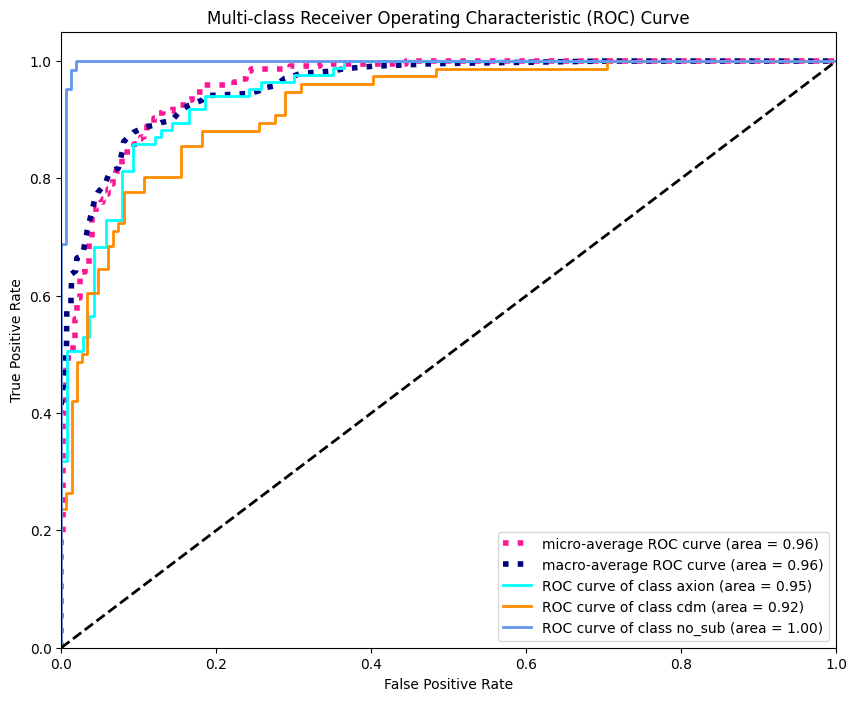

In [ ]:
"""
Args:
        image_size (int): Size of the input image (e.g., 224).
        patch_size (int): Size of each patch (e.g., 16).
        in_channels (int): Number of input channels (e.g., 1 for your task).
        num_classes (int): Number of output classes (e.g., 3 for your task).
        embed_dim (int): The main embedding dimension (e.g., 768 for ViT-Base).
        depth (int): Number of Transformer Encoder blocks (e.g., 12 for ViT-Base).
        num_heads (int): Number of attention heads (e.g., 12 for ViT-Base).
        mlp_ratio (float): Ratio to determine MLP hidden dimension (e.g., 4.0).
        dropout (float): Dropout probability.
"""
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, SequentialLR
batch_size = 32
learning_rate = 1e-4
weight_decay = 0.05
num_epochs = 2000
warmup_epochs = 10
model = SwinTransformerForClassification(
        img_size=(150, 150),
        patch_size=(10, 10),
        in_chans=1,
        num_classes=3,
        embed_dim=48,
        depths=[2, 2, 2],
        num_heads=[3, 6, 12],
        window_size=(5, 5),
        use_relativistic_encoder=True, # <-- Set to True
        relativistic_encoder_blocks=2  # <-- Hyperparameter for the new encoder
    )


criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)


#scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)
def warmup_lambda(current_epoch):
    if current_epoch < warmup_epochs:
        return float(current_epoch) / float(max(1, warmup_epochs))
    return 1.0
warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)
main_scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs - warmup_epochs, eta_min=1e-6)
scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, main_scheduler], milestones=[warmup_epochs])


print("Optimizer: Adam")
print(f"Learning Rate: {learning_rate}")

# Train Model
model, all_probs, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

""" ROC Curve Plotting Function"""
def plot_roc_curve(all_preds, all_labels):
    print("Generating ROC Curve")

    # Convert predictions and labels to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 3

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_preds[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        print(f"Class {i} ROC AUC: {roc_auc[i]:.4f}")

    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green']
    class_names = ['Axion', 'CDM', 'No Substructure']

    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig('/content/drive/MyDrive/Model_III_dataset/roc_curve_swin_pinn.png')
    plt.close()

    print("ROC Curve saved as roc_curve.png")


plot_roc_curve(all_probs, all_labels)

print("Training and Evaluation Complete!")